In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
tester_results_dir = "[5] Tester Results"

analyzer_results_dir = "[3] Test Input"

peakfinder_results_dir = "[1] PeakFinder Results"

output_dir = "[6] Plot Results"

In [3]:
os.makedirs(output_dir, exist_ok=True)

dfs = {}

for results_dir, prefix in [
    ("[5] Tester Results", "TESTER"),
    ("[3] Test Input", "ANALYZER"),
    ("[1] PeakFinder Results", "PEAKFINDER")
]:
    files = [file for file in os.listdir(results_dir) if file.endswith(('.xlsx', '.xls')) and not file.startswith('RT') and not file.startswith('OVERVIEW')]
    for file in files:
        file_path = os.path.join(results_dir, file)
        key = f"{prefix}_{file.split('.')[0]}"
        dfs[key] = pd.read_excel(file_path)

print(list(dfs.keys()))
print(f"Loaded {len(dfs)} dataframes from all results directories.")

['TESTER_ALL_VAR_CORRELATIONS_PARAMETRIC', 'TESTER_CORRELATIONS_BY_SEX_DATE_PARAMETRIC', 'TESTER_INTRATRIAL_DIFFERENCES_SIGNIFICANT', 'TESTER_MEAN_VARIABLES_BY_DATE_SEX', 'TESTER_REACTION_PEAKVALUE_TONE_IN_NOISE_DIFF_MERGED_DATE', 'TESTER_RECORDER_EFFECT_AVG_BY_SEX_METRIC', 'TESTER_RECORDER_EFFECT_RANGE_BY_SEX_METRIC', 'TESTER_SIGNIFICANT_DATE_SPLIT', 'TESTER_SIGNIFICANT_RECORDER_COUNTS_PARAMETRIC', 'TESTER_SIGNIFICANT_RECORDER_SPLIT_PARAMETRIC', 'TESTER_SIGNIFICANT_SEX_SPLIT_REACTION_PARAMETRIC', 'TESTER_SIGNIFICANT_SEX_SPLIT_STRENGTH_PARAMETRIC', 'TESTER_STRENGTH_METRIC_MEAN_DIFF_BY_DATE', 'TESTER_TEST_DATE_MERGED_SEX_PARAMETRIC', 'TESTER_TEST_DATE_PARAMETRIC', 'TESTER_TEST_EXPERIMENT_ALL_VARIABLES_PARAMETRIC', 'TESTER_TEST_PEAKTIME_REACTIONTIME_TO_STRENGTH_PARAMETRIC', 'TESTER_TEST_REC_ORDER_DIRECTION', 'TESTER_TEST_REPETITION_PARAMETRIC', 'TESTER_TEST_SEX_AVG_ACROSS_DATES_PARAMETRIC', 'TESTER_TEST_SEX_PARAMETRIC', 'TESTER_TEST_SEX_RANGE_ACROSS_DATES_PARAMETRIC', 'TESTER_TRAILING_NU

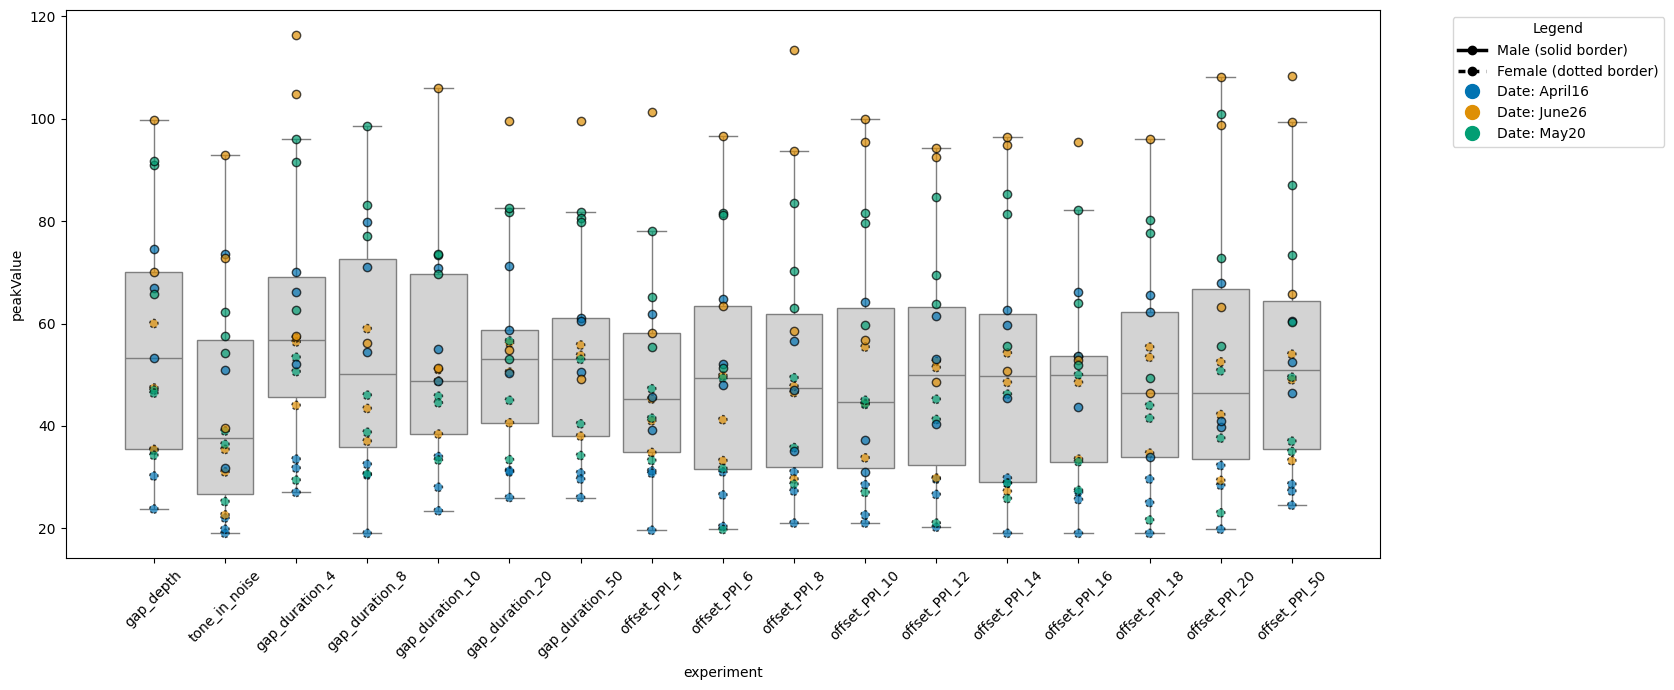

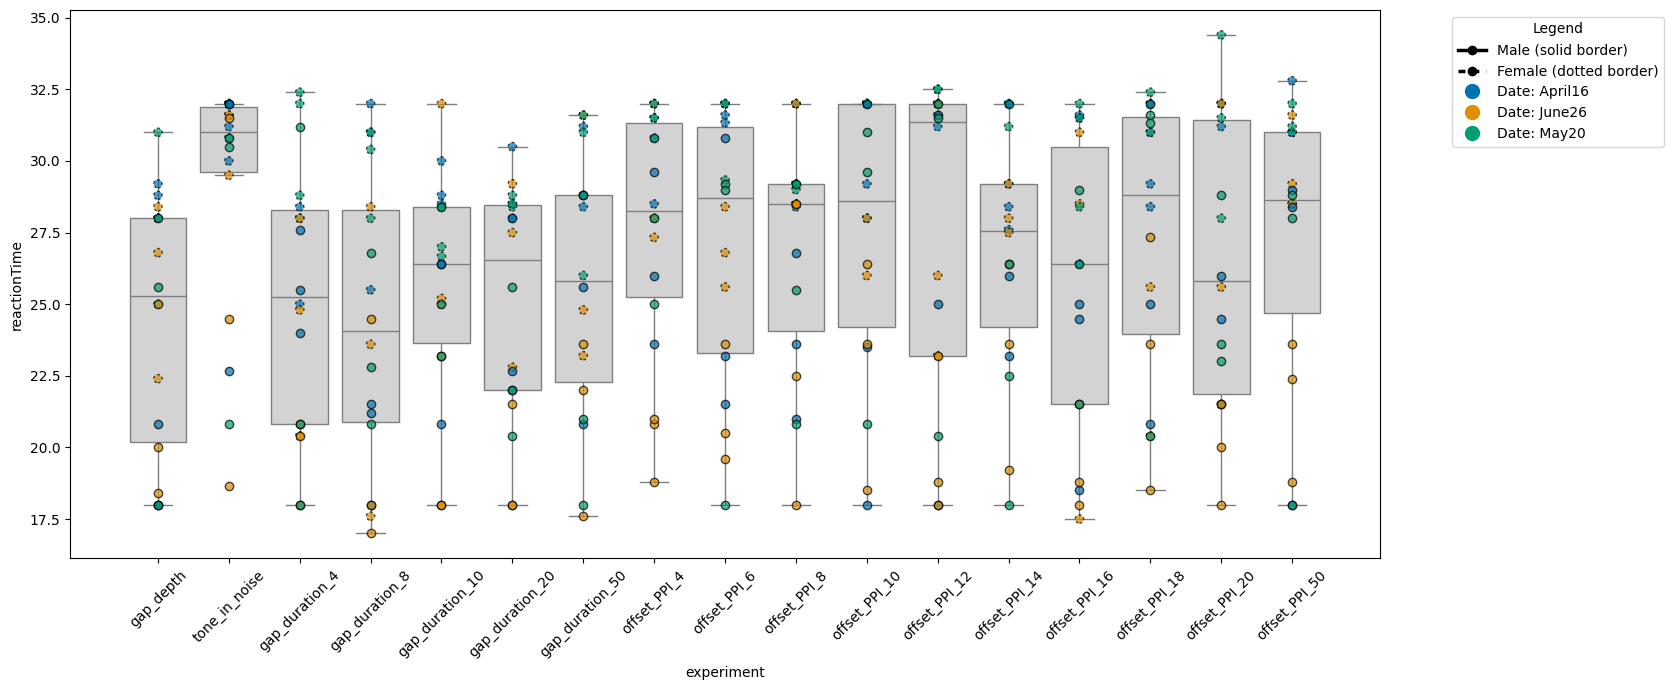

In [4]:
import matplotlib.lines as mlines

def get_dfs_key_for_df(df, dfs_dict):
    for key, obj in dfs_dict.items():
        if obj is df:
            return key
    return None

def plot_test_experiment(df_main, output_dir, variable='peakValue'):
    # Exclude extreme outliers (outside 1.5*IQR)
    Q1 = df_main[variable].quantile(0.25)
    Q3 = df_main[variable].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_main = df_main[(df_main[variable] >= lower_bound) & (df_main[variable] <= upper_bound)]

    plt.figure(figsize=(14,7))
    # Boxplot
    sns.boxplot(data=df_main, x='experiment', y=variable, color='lightgray', showfliers=False, zorder=1)
    # Colorblind-friendly palette for dates
    unique_dates = sorted(df_main['date'].unique())
    palette = sns.color_palette("colorblind", n_colors=len(unique_dates))
    date_color_map = {date: palette[i] for i, date in enumerate(unique_dates)}
    # Scatterplot overlay, manual for border style
    linewidth_map = {'male': 1, 'female': 1}
    linestyle_map = {'male': 'solid', 'female': (0, (2, 2))}  # dotted for female

    for sex in df_main['sex'].unique():
        sub = df_main[df_main['sex'] == sex]
        for date in unique_dates:
            sub_date = sub[sub['date'] == date]
            color = date_color_map[date]  # Ensure each date gets its unique color
            for i, row in sub_date.iterrows():
                plt.scatter(
                    x=row['experiment'],
                    y=row[variable],
                    color=color,
                    edgecolors='black',
                    linewidths=linewidth_map[sex],
                    linestyle=linestyle_map[sex],
                    alpha=0.7,
                    marker='o',
                    zorder=2
                )
    df_key = get_dfs_key_for_df(df_main, dfs)

    """ # Fix: handle None case for df_key
    if df_key is not None and 'FIT' in df_key:
        plt.title(f'{variable} by Experiment (Scatter: Date Color, Sex Border Style; quantile fit)')
    else:
        plt.title(f'{variable} by Experiment (Scatter: Date Color, Sex Border Style)') """

    plt.ylabel(variable)
    plt.xlabel('experiment')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'TEST_EXPERIMENT_{variable}_SCATTERBOX_{df_key}.png'))

    # Custom legend for sex border style
    male_handle = mlines.Line2D([], [], color='black', linestyle='solid', linewidth=2.5, marker='o', label='Male (solid border)')
    female_handle = mlines.Line2D([], [], color='black', linestyle=(0, (2,2)), linewidth=2.5, marker='o', label='Female (dotted border)')
    sex_legend = [male_handle, female_handle]

    # Custom legend for date colors
    date_handles = [
        mlines.Line2D([], [], color=date_color_map[date], marker='o', linestyle='None', markersize=10, label=f'Date: {date}')
        for date in unique_dates
    ]

    # Combine legends
    handles = sex_legend + date_handles
    plt.legend(handles=handles, title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()


plot_test_experiment(dfs['ANALYZER_RESULTS_MTT_MERGED'], output_dir, 'peakValue')
#plot_test_experiment(dfs['ANALYZER_RESULTS_MTT_MERGED_FIT'], output_dir, 'peakValue')
plot_test_experiment(dfs['ANALYZER_RESULTS_MTT_MERGED'], output_dir, 'reactionTime')
#plot_test_experiment(dfs['ANALYZER_RESULTS_MTT_MERGED_FIT'], output_dir, 'reactionTime')
# ...existing code...

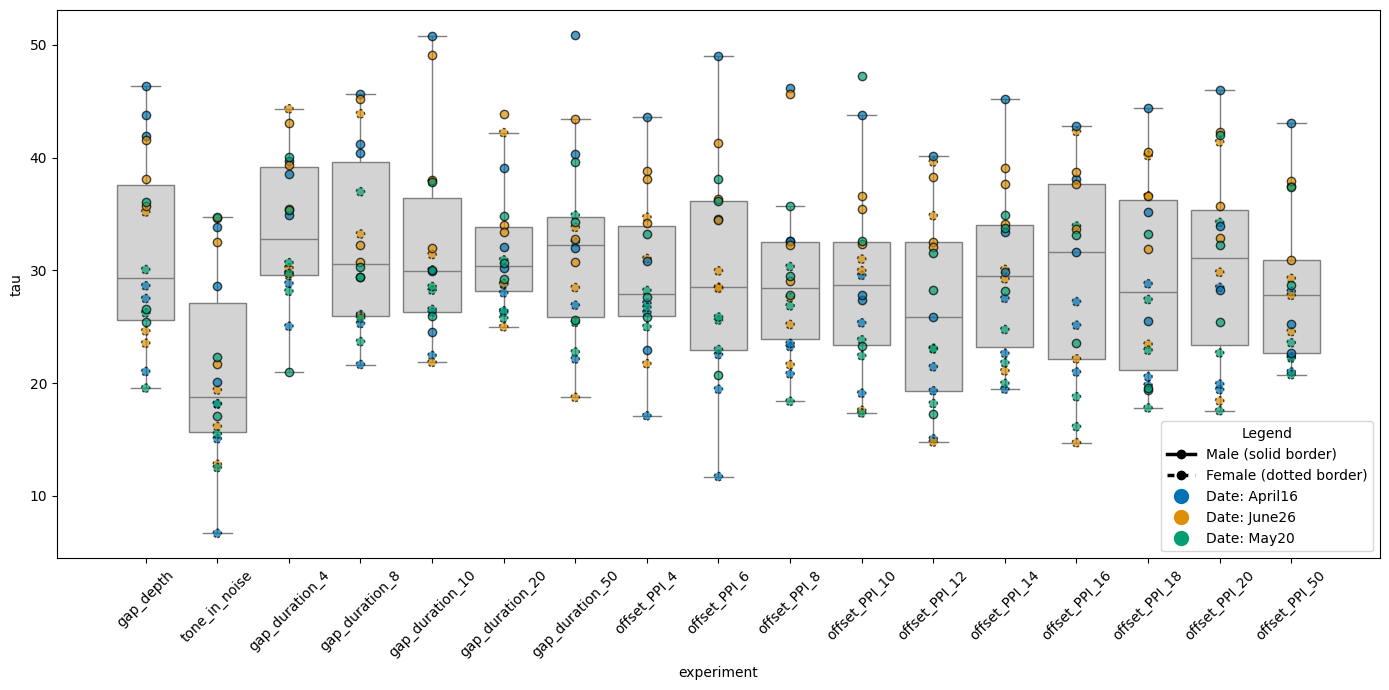

In [5]:
# ...existing code...
FIG_WIDTH = 14
FIG_HEIGHT = 7

def plot_test_experiment(df_main, output_dir, variable='peakValue', remove_xaxis=False, remove_legend=False):
    # Exclude extreme outliers (outside 1.5*IQR)
    Q1 = df_main[variable].quantile(0.25)
    Q3 = df_main[variable].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_main = df_main[(df_main[variable] >= lower_bound) & (df_main[variable] <= upper_bound)]

    plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))  # Use fixed width and height
    # Boxplot
    sns.boxplot(data=df_main, x='experiment', y=variable, color='lightgray', showfliers=False, zorder=1)
    # ...existing code...
    # Colorblind-friendly palette for dates
    unique_dates = sorted(df_main['date'].unique())
    palette = sns.color_palette("colorblind", n_colors=len(unique_dates))
    date_color_map = {date: palette[i] for i, date in enumerate(unique_dates)}
    # Scatterplot overlay, manual for border style
    linewidth_map = {'male': 1, 'female': 1}
    linestyle_map = {'male': 'solid', 'female': (0, (2, 2))}  # dotted for female

    for sex in df_main['sex'].unique():
        sub = df_main[df_main['sex'] == sex]
        for date in unique_dates:
            sub_date = sub[sub['date'] == date]
            color = date_color_map[date]
            for i, row in sub_date.iterrows():
                plt.scatter(
                    x=row['experiment'],
                    y=row[variable],
                    color=color,
                    edgecolors='black',
                    linewidths=linewidth_map[sex],
                    linestyle=linestyle_map[sex],
                    alpha=0.7,
                    marker='o',
                    zorder=2,
                )
    df_key = get_dfs_key_for_df(df_main, dfs)

    plt.ylabel(variable)
    if not remove_xaxis:
        plt.xlabel('experiment')
        plt.xticks(rotation=45)
    else:
        plt.xlabel('')
        plt.xticks([])

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'TEST_EXPERIMENT_{variable}_SCATTERBOX_{df_key}.png'))

    # Custom legend for sex border style
    male_handle = mlines.Line2D([], [], color='black', linestyle='solid', linewidth=2.5, marker='o', label='Male (solid border)')
    female_handle = mlines.Line2D([], [], color='black', linestyle=(0, (2,2)), linewidth=2.5, marker='o', label='Female (dotted border)')
    sex_legend = [male_handle, female_handle]

    # Custom legend for date colors
    date_handles = [
        mlines.Line2D([], [], color=date_color_map[date], marker='o', linestyle='None', markersize=10, label=f'Date: {date}')
        for date in unique_dates
    ]

    # Combine legends
    handles = sex_legend + date_handles
    if not remove_legend:
        plt.legend(handles=handles, title='Legend')
    plt.show()

# Top plot: remove x axis
#plot_test_experiment(dfs['ANALYZER_RESULTS_MTT_MERGED'], output_dir, 'peakValue', remove_xaxis=True, remove_legend=False)
# Bottom plot: remove legend
#plot_test_experiment(dfs['ANALYZER_RESULTS_MTT_MERGED'], output_dir, 'reactionTime', remove_xaxis=False, remove_legend=True)
# ...existing code...

plot_test_experiment(dfs['ANALYZER_RESULTS_MTT_MERGED'], output_dir, 'tau', remove_xaxis=False, remove_legend=False)

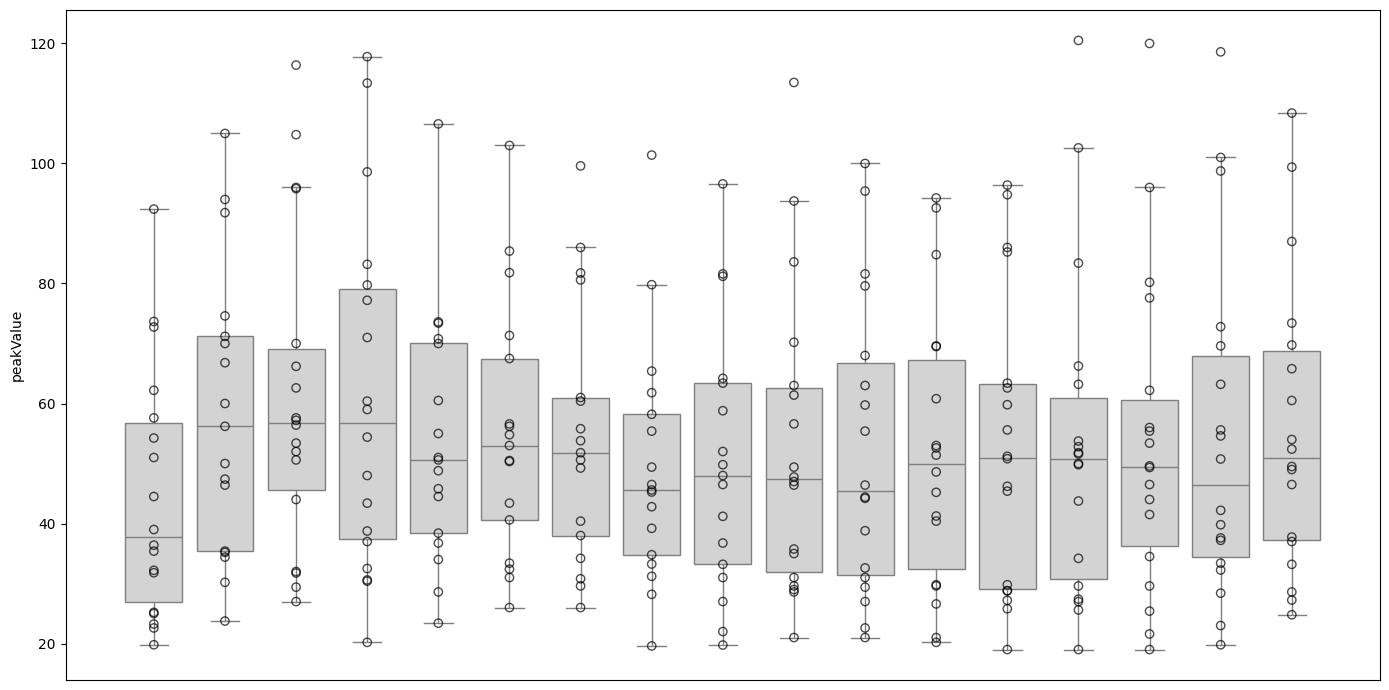

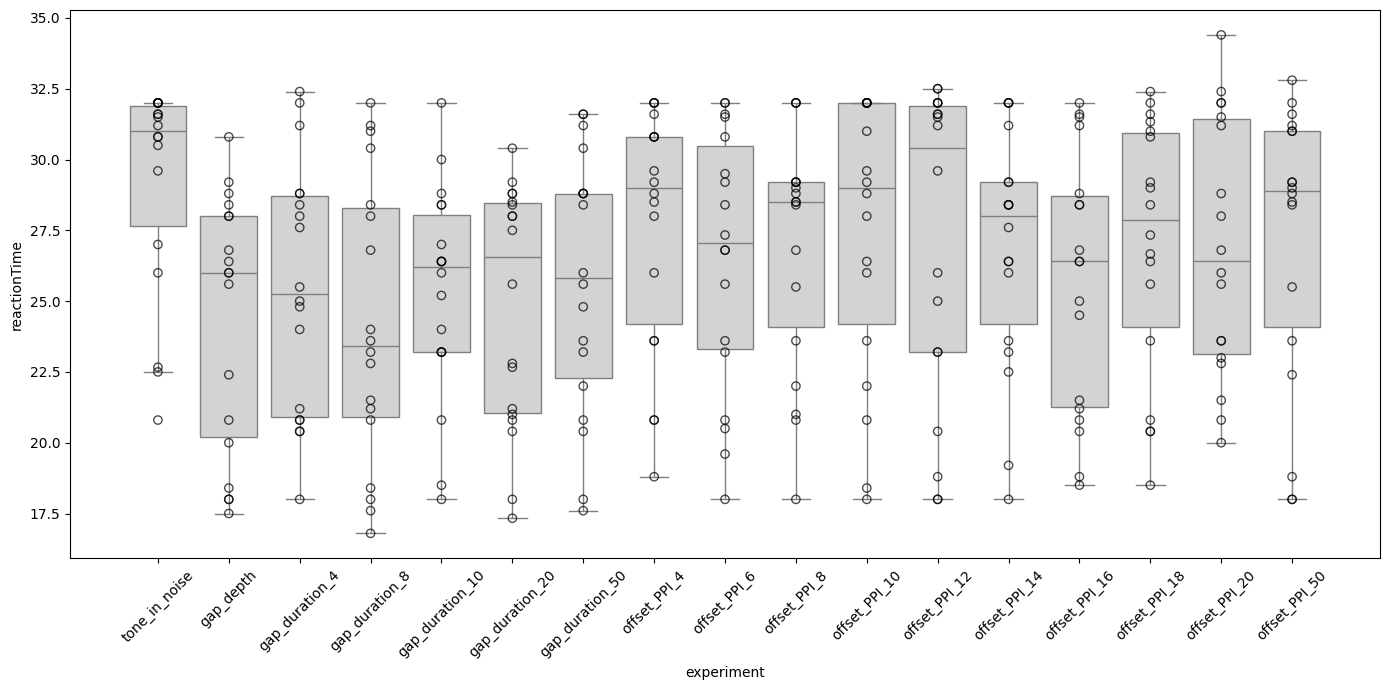

In [8]:
def plot_test_experiment(df_main, output_dir, variable='peakValue', remove_xaxis=False, remove_legend=False):
    # Exclude extreme outliers (outside 1.5*IQR)
    Q1 = df_main[variable].quantile(0.25)
    Q3 = df_main[variable].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_main = df_main[(df_main[variable] >= lower_bound) & (df_main[variable] <= upper_bound)]

    # Set experiment order: tone_in_noise before gap_depth, rest as found
    experiments = list(df_main['experiment'].unique())
    if 'tone_in_noise' in experiments and 'gap_depth' in experiments:
        experiments = [e for e in experiments if e not in ['tone_in_noise', 'gap_depth']]
        order = ['tone_in_noise', 'gap_depth'] + experiments
    else:
        order = experiments

    plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))
    # Boxplot with custom order
    sns.boxplot(data=df_main, x='experiment', y=variable, color='lightgray', showfliers=False, zorder=1, order=order)

    # Scatterplot overlay: all points identical marker, color, border
    for i, row in df_main.iterrows():
        plt.scatter(
            x=row['experiment'],
            y=row[variable],
            color='none',           # All points black
            edgecolors='black',      # Black border
            linewidths=1,            # Standard border width
            alpha=0.7,
            marker='o',
            zorder=2,
        )

    df_key = get_dfs_key_for_df(df_main, dfs)

    plt.ylabel(variable)
    if not remove_xaxis:
        plt.xlabel('experiment')
        plt.xticks(rotation=45)
    else:
        plt.xlabel('')
        plt.xticks([])

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'TEST_EXPERIMENT_{variable}_SCATTERBOX_{df_key}.png'))

    # Legend removed (no color/border distinction)
    plt.show()


# Top plot: remove x axis
plot_test_experiment(dfs['ANALYZER_RESULTS_MERGED'], output_dir, 'peakValue', remove_xaxis=True, remove_legend=False)
# Bottom plot: remove legend
plot_test_experiment(dfs['ANALYZER_RESULTS_MERGED'], output_dir, 'reactionTime', remove_xaxis=False, remove_legend=True)